<h1>Mini-Batch Gradient Descent: PyTorch</h1> 


<h2>Objective</h2><ul><li> How to use PyTorch build-in functions to create a model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will create a model the PyTroch way, this will help you as models get more complicated</p>

<ul>
    <li><a href="#Make-Some-Data">Make Some Data </a></li>
    <li><a href="#Create-the-Model-and-Total-Loss-Function-(Cost)">Create the Model and Total Loss Function (Cost) </a></li>
    <li><a href="#Train-the-Model:-Batch-Gradient-Descent">Train the Model: Batch Gradient Descent</a></li>
</ul>

<h2>Preparation</h2>


We'll need the following libraries:  


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with PyTorch. 


In [3]:
class plot_error_surfaces(object):
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.LOSS.append(loss)
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n) )
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<!-- <h2 id="Makeup_Data">Make Some Data</h2>
 -->
 ## Make Some Data


Import libraries and set random seed.


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(1)

Generate values from -3 to 3 that create a line with a slope of 1 and a bias of -1. This is the line that you need to estimate. Add some noise to the data:


In [5]:
class Data(Dataset):
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.f = 1 * self.x - 1
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        self.len = self.x.shape[0]
        
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.len

Create a dataset object: 


In [6]:
dataset = Data()

Plot out the data and the line.


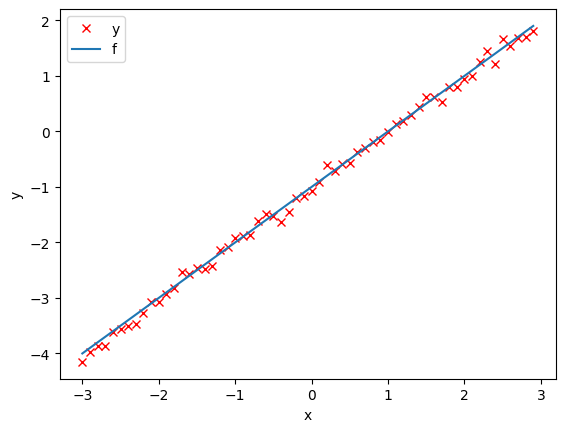

In [7]:
plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'rx', label = 'y')
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<!-- <h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>
 -->
## Create the Model and Total Loss Function (Cost)


Create a linear regression class 


In [13]:
from torch import nn, optim

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.linear(x)

We will use PyTorch build-in functions to create a criterion function; this calculates the total loss or cost 


In [10]:
criterion = nn.MSELoss()

Create a linear regression object and optimizer object, the optimizer object will use the linear regression object.


In [20]:
model = LinearRegression(1,1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.9261]], requires_grad=True),
 Parameter containing:
 tensor([0.5034], requires_grad=True)]

Remember to construct an optimizer you have to give it an iterable containing the parameters i.e. provide <code>model.parameters()</code> as an input to the object constructor 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4model_optmiz.png" width="100" alt="Model Optimizer">


Similar to the model, the optimizer has a state dictionary:


In [16]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

Many of the keys correspond to more advanced optimizers.


Create a <code>Dataloader</code> object: 


In [22]:
trainloader = DataLoader(dataset=dataset, batch_size=1)

PyTorch randomly initialises your model parameters. If we use those parameters, the result will not be very insightful as convergence will be extremely fast. So we will initialise the parameters such that they will take longer to converge, i.e. look cool  


In [23]:
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10

Create a plotting object, not part of PyTroch, just used to help visualize 


In [24]:
get_surface = plot_error_surfaces(15, 13, dataset.x, dataset.y, 30, go = False)

<!-- <h2 id="BGD">Train the Model via Batch Gradient Descent</h2>
 -->
 ## Train the Model: Batch Gradient Descent


Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


In [ ]:
def train_model_BGD(iter):
    for epoch in range(iter):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(model, loss.tolist())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        get_surface.plot_ps()

train_model_BGD(10)

In [ ]:
model.state_dict()

Let's use the following diagram to help clarify the process. The model takes <code>x</code> to produce an estimate <code>yhat</code>, it will then be compared to the actual <code>y</code>  with the loss function.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4get_loss.png" width="400" alt="Old Model Cost diagram">


When we call <code>backward()</code> on the loss function, it will handle the differentiation. Calling the method step on the optimizer object it will update the parameters as they were inputs when we constructed the optimizer object. The connection is shown in the following figure :



<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4update_param.png" width="500" alt="Model Cost with optimizer">


<h3>Practice</h3>


Try to train the model via BGD with <code>lr = 0.1</code>. Use <code>optimizer</code> and the following given variables.


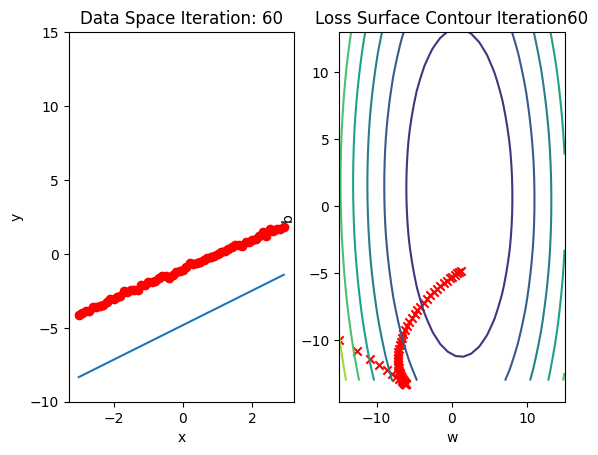

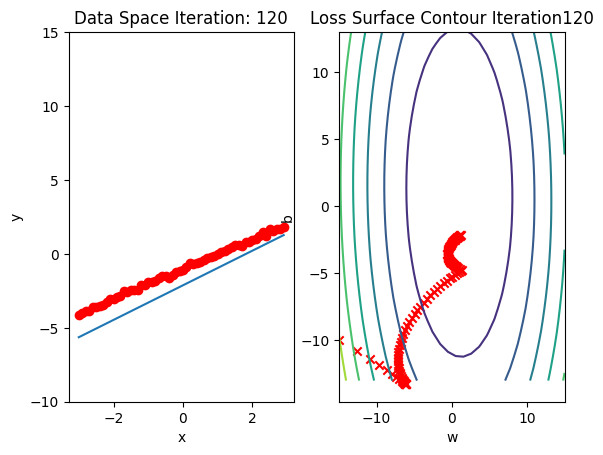

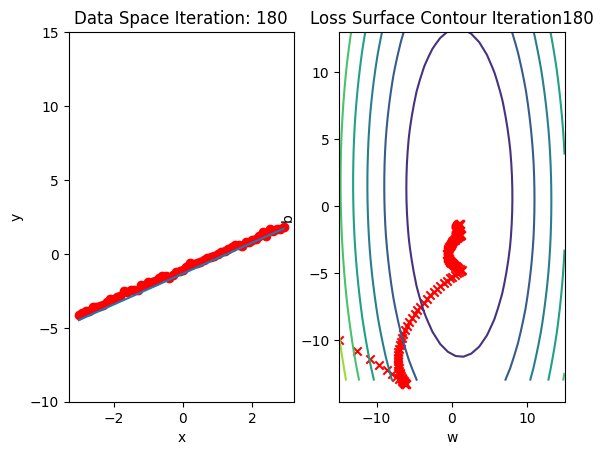

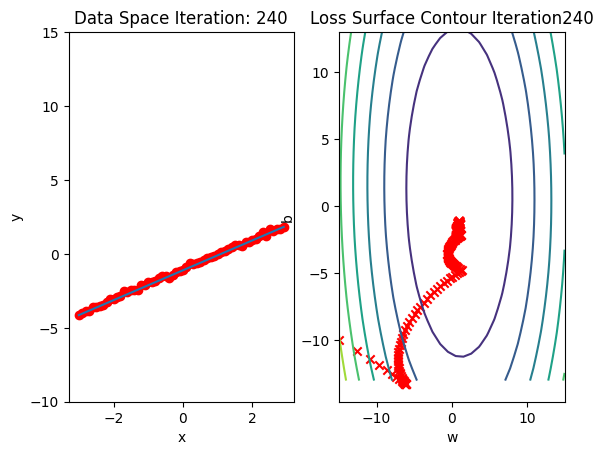

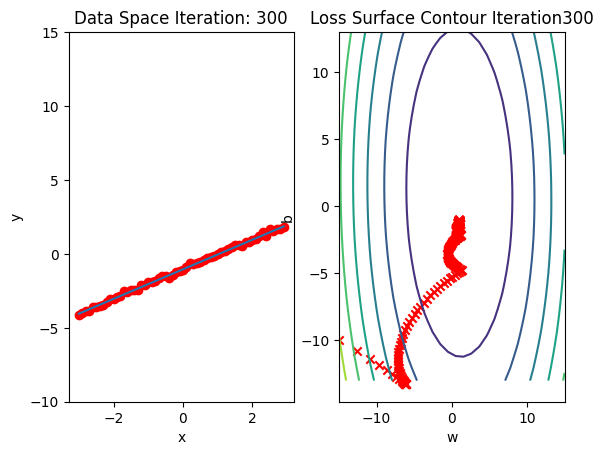

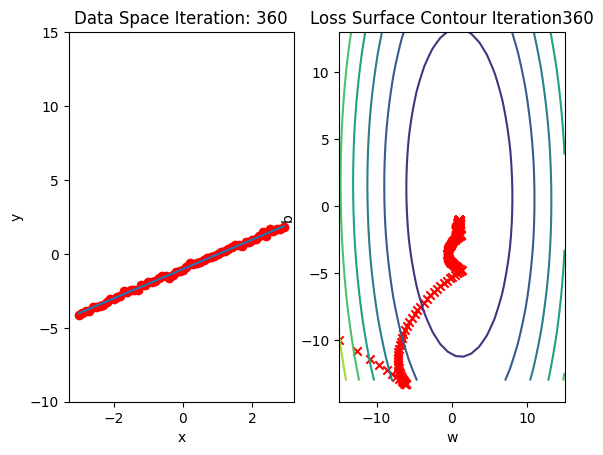

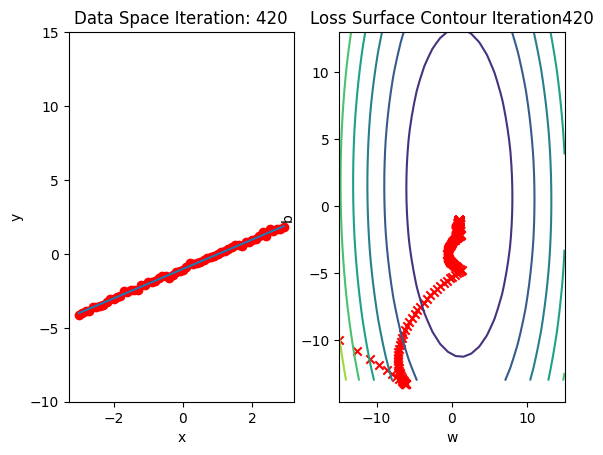

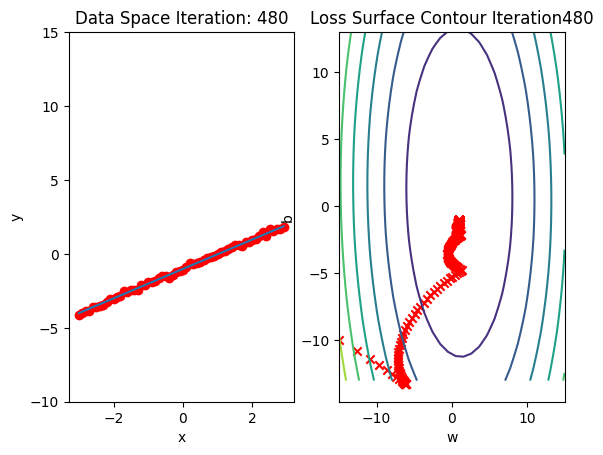

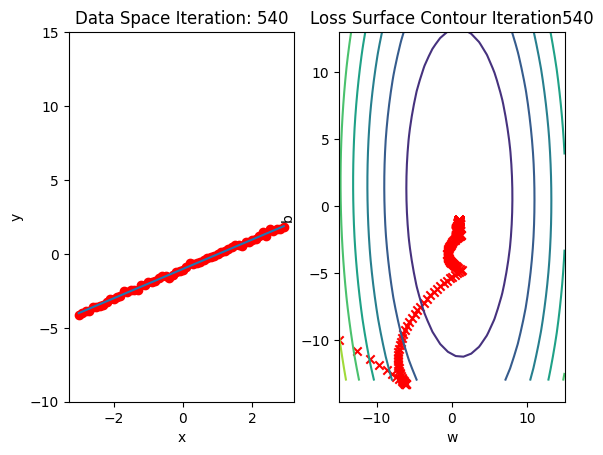

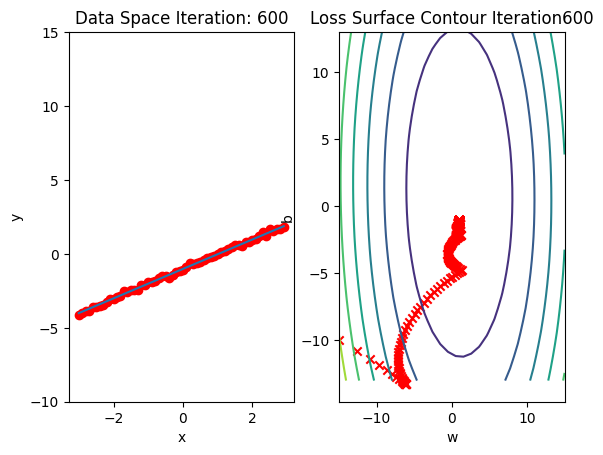

In [27]:
model = LinearRegression(1,1)
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10

get_surface = plot_error_surfaces(15, 13, dataset.x, dataset.y, 30, go = False)

optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(10):
    for x, y in trainloader:
        yhat = model(x)
        loss = criterion(yhat, y)
        get_surface.set_para_loss(model, loss.tolist())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    get_surface.plot_ps()